# Example 10.3 Animation of a wind field

This example shows the generation and animation of a turbulence wind field along a bridge span. The example uses a Kaimal spectral density $S_u(\omega)$ for the wind turbulence and a exponential (Davenport) model for the coherence $\hat{\text{Co}}(\omega,\Delta x)$.


$$ S_u(\omega,\Delta x)
=S_u(\omega)\hat{\text{Co}}(\omega,\Delta x)$$

Parameters that can be specified:

*Geometry parameters*:
- L: length of span
- N: number of points along the span


*Wind field parameters*:
- U_mean: mean wind speed
- Iu: turbulence intensity
- L_u: integral length scale of the turbulence
- C: Davenport decay parameter for the coherence

*Simulation parameters*:
- dt: time step
- T:  duration



### Python code

The code below generates the cross-spectral density matrix of the wind field and simulates time series of turbulence.


*Note*: simulation of multivariate stochastic processes (from a matrix $\mathbf{S}(\omega)$ rather than a scalar $S(\omega)$ is not part of the curriculum). However, it can be performed similar to the sum of cosine or IFFT-based methods.


In [12]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.close('all')
# ----------------------------
# Models
# ----------------------------
def kaimal_su(f, U_mean, sigma_u, L_u):
    """
    Kaimal longitudinal spectrum (one common form).
    S_u(f) = (4 sigma_u^2 L_u / U) / (1 + 6 f L_u / U)^(5/3)
    """
    f = np.asarray(f)
    Su = (4.0 * sigma_u**2 * L_u / U_mean) / (1.0 + 6.0 * f * L_u / U_mean)**(5.0/3.0)
    Su[f == 0.0] = 0.0
    return Su

def davenport_coh(f, dx, U_mean, C):
    """
    Davenport exponential coherence:
    gamma_ij(f) = exp( - C * f * |x_i - x_j| / U_mean )
    """
    return np.exp(-C * f[:, None, None] * dx[None, :, :] / U_mean)

# ----------------------------
# CPSD assembly for homogeneous line
# ----------------------------
def cpsd_matrix(f, x, U_mean, sigma_u, L_u, C):
    """
    Build S(f_k) \in R^{N x N} for each frequency f_k.
    Homogeneous: same auto-PSD at all points. Coherence = Davenport.
    """
    N = x.size
    dx = np.abs(x[:, None] - x[None, :])
    Su = kaimal_su(f, U_mean, sigma_u, L_u)           # shape (K,)
    G = davenport_coh(f, dx, U_mean, C)                # shape (K,N,N)
    # autospectra matrix sqrt factors per freq
    sroot = np.sqrt(Su)                                 # (K,)
    # outer for autospectra at each freq: sqrt(Sii)*sqrt(Sjj) = Su
    # Since homogeneous, Sii=Su, so sqrt(Sii*Sjj) = Su
    # Then apply coherence:
    S = G * Su[:, None, None]
    # Enforce symmetry
    S = 0.5 * (S + np.transpose(S, (0, 2, 1)))
    return S  # shape (K, N, N)

# ----------------------------
# Spectral simulation via IFFT (Shinozuka-type)
# ----------------------------
def simulate_multivariate_time_series(Sf, df, dt, T, seed=None):
    """
    Simulate correlated multivariate Gaussian wind field using
    Cholesky decomposition of CPSD matrices and random phases.

    Parameters
    ----------
    Sf : array (K, N, N)
        Cross-spectral density matrices for positive frequencies (excluding DC, Nyquist)
    df : float
        Frequency resolution [Hz]
    dt : float
        Time step [s]
    T : float
        Total duration [s]
    seed : int, optional
        Random seed

    Returns
    -------
    u : array (Nt, N)
        Simulated wind fluctuations
    """
    if seed is not None:
        np.random.seed(seed)

    Nt = int(np.round(T / dt))
    nfft = int(2 ** np.ceil(np.log2(Nt)))
    Nt = nfft
    N = Sf.shape[1]

    # frequency bins
    K = Sf.shape[0]
    nfreq = nfft // 2 + 1
    freqs = np.fft.rfftfreq(nfft, d=dt)
    df_check = freqs[1] - freqs[0]
    assert abs(df_check - df) / df < 1e-3, 'df mismatch'

    # complex Fourier coefficients
    U_hat = np.zeros((nfreq, N), dtype=np.complex128)

    # DC and Nyquist components set to zero mean
    U_hat[0, :] = 0.0
    if nfft % 2 == 0:
        U_hat[-1, :] = 0.0

    # Loop over positive frequencies (excluding 0 and Nyquist)
    for k in range(1, K + 1):
        S_k = 0.5 * (Sf[k - 1] + Sf[k - 1].T)  # symmetrize
        # Ensure positive definiteness
        S_k += 1e-12 * np.eye(N)

        # Cholesky factor
        try:
            L = np.linalg.cholesky(S_k)
        except np.linalg.LinAlgError:
            # fallback: small regularization
            L = np.linalg.cholesky(S_k + 1e-8 * np.eye(N))

        # Random phase angles uniformly in [0, 2π)
        phi = 2 * np.pi * np.random.rand(N)
        z = np.exp(1j * phi)  # unit magnitude complex vector

        # Apply Cholesky transform and sqrt(df) scaling
        U_hat[k, :] = np.sqrt(2 * df) * (L @ z)

    # Hermitian symmetry
    full_spec = np.zeros((nfft, N), dtype=np.complex128)
    full_spec[:nfreq, :] = U_hat
    full_spec[nfreq:, :] = np.conj(U_hat[1:-1, :][::-1, :])

    # IFFT to time domain
    u = np.fft.ifft(full_spec, axis=0).real * nfft
    return u

# ----------------------------
# High-level helper
# ----------------------------
def generate_wind_field(L=200.0, N=21, U_mean=15.0, Iu=0.15, L_u=50.0, C=12.0,
                        dt=0.1, T=600.0, seed=1):
    """
    Returns:
      t: (Nt,)
      x: (N,)
      u_fluct: (Nt, N)
      U_mean: float
    """
    x = np.linspace(0.0, L, N)
    Nt = int(2**np.ceil(np.log2(T/dt)))
    nfft = Nt
    t = np.arange(nfft) * dt
    df = 1.0 / (nfft * dt)
    freqs = np.fft.rfftfreq(nfft, d=dt)
    K = nfft//2 - 1  # positive freqs excluding DC and Nyquist
    fpos = freqs[1:K+1]

    sigma_u = Iu * U_mean

    # CPSD over positive frequencies
    Sf = cpsd_matrix(fpos, x, U_mean, sigma_u, L_u, C)  # (K, N, N)

    # Simulate
    u_fluct = simulate_multivariate_time_series(Sf, df, dt, t[-1] + dt, seed=seed)

    return t, x, u_fluct, U_mean

# ----------------------------
# Animation
# ----------------------------
def animate_field(t, x, u_fluct, U_mean, stride=1, scale=1.0, fps=20):
    """
    Animate the wind field as vertical arrows at positions x.
    Each arrow length ∝ (U_mean + u_fluct), direction = +y.
    Arrowhead size constant.
    """
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    import numpy as np


    # use interactive backend (important for Spyder)
    plt.switch_backend('Qt5Agg')

    # Subsample time steps for animation
    step = max(1, int(np.floor((1.0 / fps) / (t[1] - t[0]))))
    t_sub = t[::step]
    u_sub = u_fluct[::step, :]

    X = x
    Y = np.zeros_like(x)

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.set_xlim(X.min() - 1, X.max() + 1)
    Lmax = np.max(U_mean + u_fluct) * scale
    ax.set_ylim(0.0, 1.1 * Lmax)
    ax.set_xlabel('x [m]')
    ax.set_ylabel('Wind velocity [m/s]')
    ax.set_title('Vertical arrows: instantaneous (U + u\')(x,t)')
    ax.grid(True, linestyle='--', alpha=0.5)

    # Initial arrows
    V = (U_mean + u_sub[0, :]) * scale
    U = np.zeros_like(V)
    Q = ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1.0,
                  width=0.005, headwidth=3, headlength=4, headaxislength=3)
    
    ax.axhline(U_mean, color='r', linestyle='--', linewidth=1.5, label='Mean wind speed')
    

    txt = ax.text(0.02, 0.9, '', transform=ax.transAxes)

    def update(i):
        V = (U_mean + u_sub[i, :]) * scale
        U = np.zeros_like(V)
        Q.set_UVC(U, V)
        txt.set_text(f't = {t_sub[i]:.2f} s')
        return Q, txt

    ani = FuncAnimation(fig, update, frames=len(t_sub),
                        interval=1000.0 / fps, blit=False)
    plt.show(block=True)


def plot_wind_time_series(t, u, x, nodes=None, nmax=5,xlim=None):
    """
    Plot wind fluctuation time series at selected nodes.

    Parameters
    ----------
    t : array (Nt,)
        Time vector [s]
    u : array (Nt, N)
        Simulated fluctuations [m/s]
    x : array (N,)
        Spatial coordinates [m]
    nodes : list[int], optional
        Indices of nodes to plot (default = evenly spaced)
    nmax : int, optional
        Max number of nodes to plot if nodes=None
    """
    Nt, N = u.shape
    if nodes is None:
        nodes = np.linspace(0, N - 1, min(N, nmax), dtype=int)

    plt.figure(figsize=(10, 4))
    for i in nodes:
        plt.plot(t, u[:, i], label=f'x={x[i]:.1f} m')
    plt.xlabel('Time [s]')
    plt.ylabel("u'(t) [m/s]")
    plt.title('Wind velocity fluctuations at selected nodes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    if xlim is not None:
        plt.xlim(xlim)

### Python code


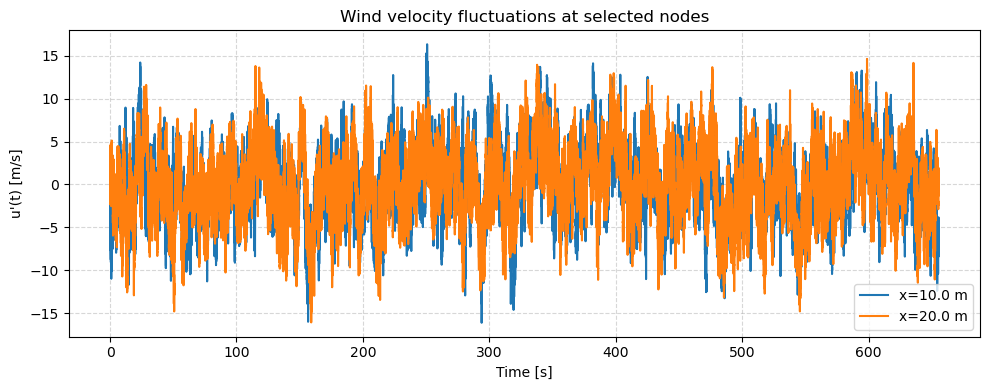

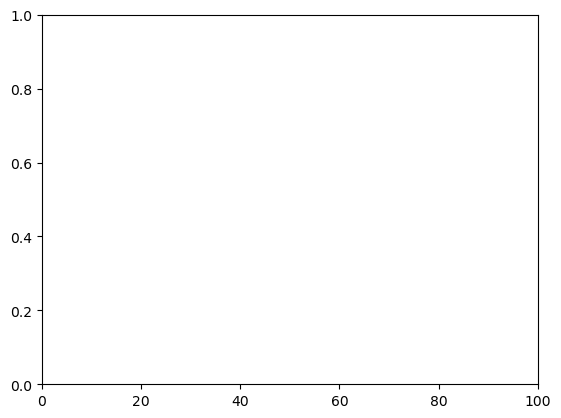

In [13]:
# ----------------------------
# Example run
# ----------------------------
    # Parameters
L = 200.0       # span length [m]
N = 21          # number of nodes
U_mean = 15.0   # mean wind speed [m/s]
Iu = 0.15       # turbulence intensity [-]
L_u = 50.0      # integral length scale [m]
C = 12.0        # Davenport decay parameter [-]
dt = 0.01        # time step [s]
T = 600.0       # duration [s]

t, x, u_fluct, U = generate_wind_field(L, N, U_mean, Iu, L_u, C, dt, T)

# Plot wind time series for two (or more) nodes along the span
plot_wind_time_series(t,u_fluct,x,nodes=[1,2],xlim=(0,100))


In [3]:



#animate_field(t, x, u_fluct, U_mean, stride=1, scale=1.0, fps=20)
